#  RDM: Identifying Strategies for the Sustainable Harvest of Prey in a Closed Predator-Prey System Under Climate Change

##  The Ecosystem

The `PredatorPreyModel` models populations of predators and prey in a closed ecosystem. The prey can be harvested by humans for human use, removing them from the ecosystem. However, if too many prey are harvested, the prey population can collapse, causing the predator population and the ecosystem to collapse. Both prey and predator are modeled using growth rates (`a` and `b`, resepctively). These growth rates are uncertain, but feasible bounds are known. 

Climate change will affect the ecosystem in uncertain ways. As temperatures changes, it affects the growth rate of the predator population. Climate change is expected to incrase, but the true magnitude is unknown. The change in temperature is the function of three uncertain parameters: 

- `C`: a climate characteristic parameter
- `F`: radiate forcing
- `S`: climate sensitivity


##  Your Task

The goal in this analysis is to identify a robust strategy for harvesting prey from the closed ecosystem that balances two objectives:

1. To maximize the **net present value of harvests (NPV)**. The net present value is the discounted value of the total harvest. If there is no harvest, then $NPV = 0$
1. To minimize **regret**. The regret is calculated as the fraction of total prey (across all time periods) not harvested. If no prey is harvested, then regret $R = 1$. 


In [2]:
##  IMPORT PACKAGES
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sys
from typing import *

# add the current directoy to the search path and load from here
dir_py = os.path.join(os.getcwd(), "python")
if dir_py not in sys.path:
    sys.path.append(dir_py)
    
import climate as cl
import predator_prey as pr
import support_functions as sf

# Setup the predator/prey model 

The model is defined as a `PredatorPrey` object, defined in `predator_prey.py`. To initialize this model, set three variables (note: these can be modified from the model projection function):
- `predator_0`: initial population, or state, of the predator. Uncertain (see below)
- `prey_0`: initial population, or state, of the prey. Uncertain
- `n_time_periods`: number of time periods to project the model for
    

In [3]:
# set some model baseline parameters
n_time_periods = 100
predator_0 = 0.26
prey_0 = 0.48

# initialize a model object
model = pr.PredatorPreyModel(
    predator_0, 
    prey_0, 
    n_time_periods,
)


# The Predatory-Prey model and the Climate model include a number of uncertain parameters


- Uncertain parameters in the predator-prey model includes:
    - `a`: the prey growth parameter, ranges from 1.5-4.0
    - `b`: the inverse of the predator growth parameter, ranges from 0.25 to 0.67 (1/4.0 - 1/1.5)
        - **NOTE**: The growth rate of predators can be affected by the change in average climate temperature, `T` 
    - `T`: the change in average temperature, which is a function of climate, driven by the following uncertain parameters:
        - `C`: Climate parameter
        - `F0`: Initial radiative forcing
        - `F`: Radiative forcing
        - `S`: climate sensitivity

    
- To run the model under uncertainty, defined some ranges associated with these parameters in a dictionary
    - `dict_parameter_values_init` maps the parameter name (dictionary key) to a dictionary with the following keys:
        - `default`: nominal value of the parameter
        - `range`: uncertain range associated with the parameter



In [4]:
# dictionary parameter names to defaults and uncertainty ranges
dict_parameter_values_init = {
    "a": {
        "default": 3.75,
        "range": (1.5, 4.0),
    },
    "b": {
        "default": 0.35,
        "range": (0.25, 0.67),
    },
    "F": {
        "default": 0.005,
        "range": (0.001, 0.03),
    },
    "S": {
        "default": 0.75,
        "range": (0.5, 2.0),
    },
}

#  1. First, let's run the predator/prey moodel under a baseline to see what the model actually computes
- Use nominal values of `a` and `b`
- The model will run with 0 harvest if no harvest is specified
    - The method `model.project()` (can be called using simply `model(`) returns a tuple of two objects:
        - 1. An output dataframe, long by time period, containing the harvest, predator population, and prey population
        - 2. A dictionary containing the Net Present Value (with key `npv`) and the Regret (key `regret`)
        
        

In [5]:
## TEMP
importlib.reload(pr)
model = pr.PredatorPreyModel(
    predator_0, 
    prey_0, 
    n_time_periods
)

# get parameters from dictionary
# a
dict_a = dict_parameter_values_init.get("a")
a_nominal = dict_a.get("default")

# b
dict_b = dict_parameter_values_init.get("b")
b_nominal = dict_b.get("default")


# run the model
df_project, dict_metrics = model(
    a_nominal, 
    b_nominal, 
)



##  1.a. The model has run under static climate and no harvesting. Let's look at some results
- Call `plot_outcomes()` to plot the results of the last run
- Can also call as `model.plot_outcomes(df_project, dict_metrics)` to plot output associated with a specific projection/score

<AxesSubplot: title={'center': 'Predator/Prey Populations and Harvest\n\nNPV = 0.0, Regret = 1.0'}, xlabel='time_period'>

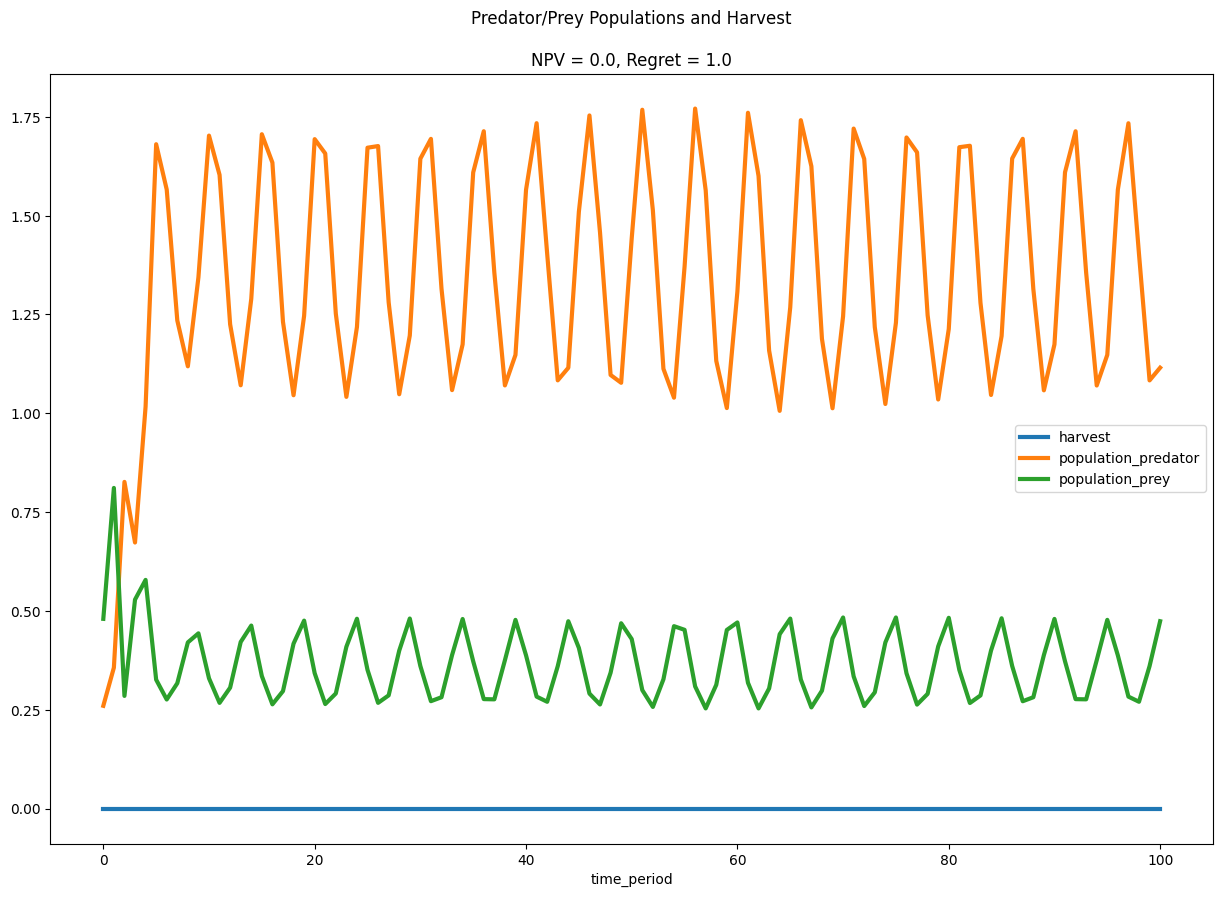

In [6]:
model.plot_outcomes()

##  1.b. Next, let's setup a strategy for harvesting and test it under stable climate (no climate change)
- The harvest function is conventionally referred to as "z"
- In each time period, the population of prey and predator in the next time step is a function of the prey and predator population minus the harvest
    - All harvests prior to t = 0 are assumed to be 0
- The function requires the following arguments (in order):
    - 1. `vec_prey`: 
        - a `numpy.ndarray` vector of prey populations (`np.array`)
        - At each time period $0 \leq t \leq T$, this will have length $t + 1$ (e.g., at time 0, it is of length 1, etc.)
    - 2. `vec_harvest`: 
        - a `numpy.ndarray` vector of previous harvests
        - At each time period $0 \leq t \leq T$, this will have length $t$ (e.g., at time 1 it has length 1, time 2 length 2, etc.)
    - 3. `temperature`:
        - scalar (integer or float) giving `delta_t` at time $t$
    - 4. `t`:
        - time period of the model. Generally useful to accessing indices in the vectors (`vec_prey` or `vec_harvest`)

**NOTE** see `model.stratgy_function_arguments_ordered` to see the ordered arguments

<AxesSubplot: title={'center': 'Predator/Prey Populations and Harvest\n\nNPV = 3.6451, Regret = 0.5357'}, xlabel='time_period'>

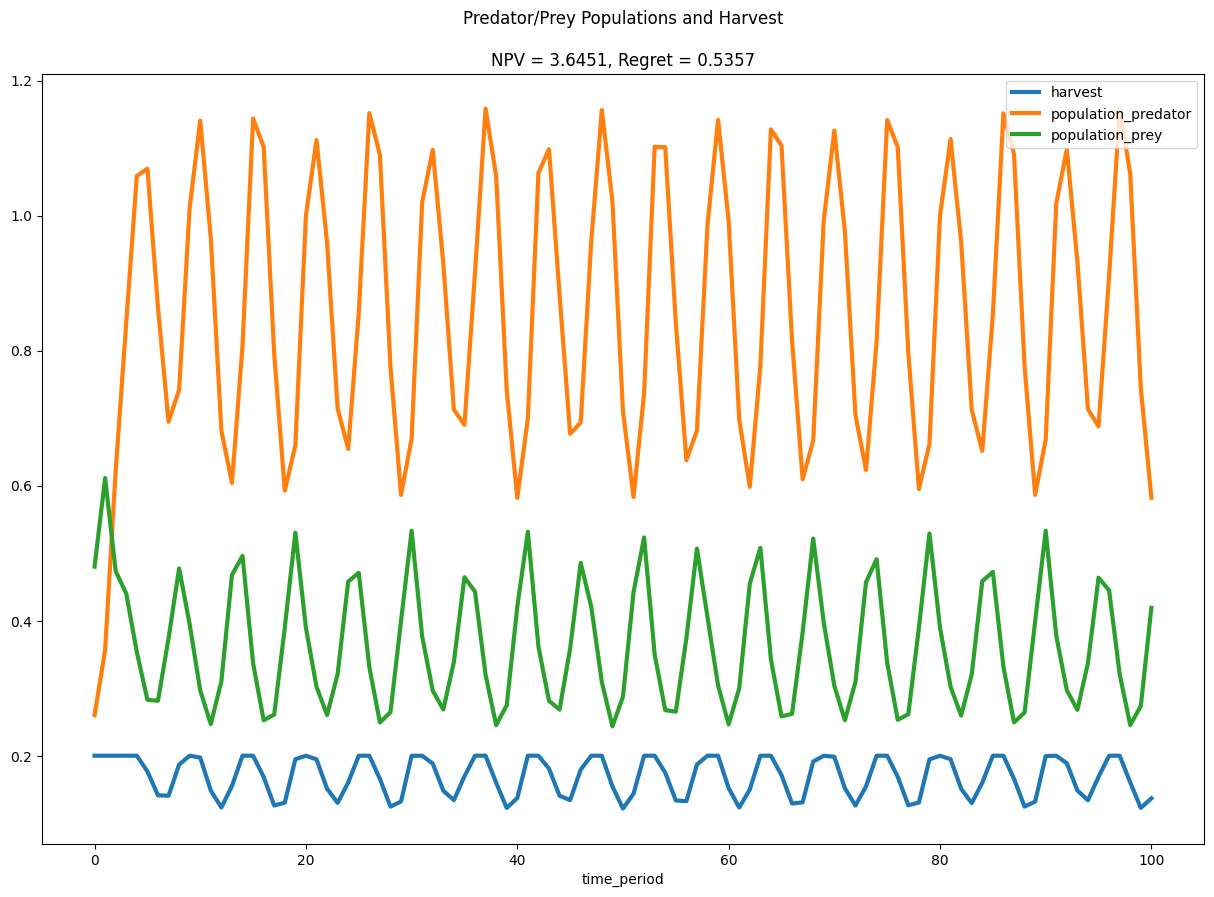

In [7]:

def harvest_soft_constant(
    vec_prey, 
    vec_harvest, 
    temperature, 
    t,
) -> float:
    """
    Example strategy, where you always harvest the minimum of either (a) a constant
        or (b) half of the prey population
    """
    # harvest whatever's less between 0.05 and half of the prey population  
    harvest_new = min(0.2, vec_prey[t]*0.5)
  
    return harvest_new




df_project, dict_metrics = model(
    a_nominal, 
    b_nominal, 
    z = harvest_soft_constant,
)



model.plot_outcomes()


##  1.c. Next, add in nominal climate change. How does the previous strategy compare?

- Recall that `F` and `S` parameters are stored in `dict_parameter_values_init`
- `F` and `S` can be set in the model as keyword arguments
- How does the constant harvest strategy compare under nominal expectations for temperature changes?



<AxesSubplot: title={'center': 'Predator/Prey Populations and Harvest\n\nNPV = -1.0, Regret = 1.0'}, xlabel='time_period'>

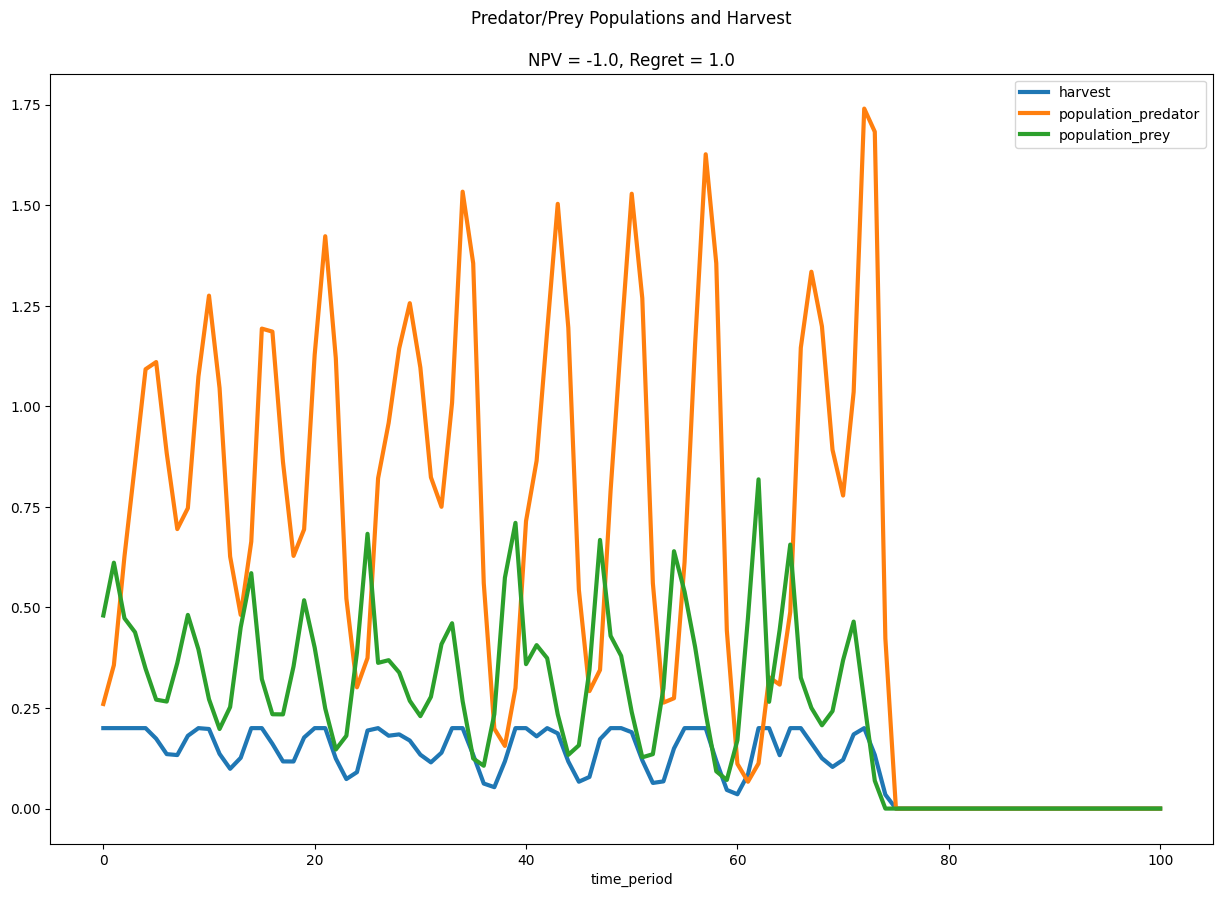

In [8]:
# get parameters from dictionary
# F
dict_F= dict_parameter_values_init.get("F")
F_nominal = dict_F.get("default")

# S
dict_S = dict_parameter_values_init.get("S")
S_nominal = dict_S.get("default")


df_project, dict_metrics = model(
    a_nominal, 
    b_nominal, 
    F = F_nominal,
    S = S_nominal,
    z = harvest_soft_constant,
)



model.plot_outcomes()

Note that the `harvest_soft_constant` strategy looked OK with no change in temperature, but increases to temperature under nominal assumptions of climate change have let to ecosystem collapse, and thus $NPV = -1.0, R = 1.0$

###  1.d. Generate some example strategies for evaluation
- These are intended to illustrate how to use the function arguments, not as dominant strategies for harvesting. **That will be your task!**

In [10]:

def harvest_soft_constant(
    vec_prey, 
    vec_harvest, 
    temperature, 
    t,
) -> float:
    """
    Example strategy, where you always harvest the minimum of either (a) a constant
        or (b) half of the prey population
    """
    # harvest whatever's less between 0.05 and half of the prey population  
    harvest_new = min(0.2, vec_prey[t]*0.5)
  
    return harvest_new



def harvest_prey_pop(
    vec_prey, 
    vec_harvest, 
    temperature, 
    t,
) -> float:
    """
    Harvest 0.1* the weighted mean of the population of prey during the current time 
        step and the population of prey in the step before
    """
    # default to 0
    harvest_new = 0
    
    # if after the 3rd time period (remember... t in [0, 1, 2, 3, ...., n_t])
    if t > 2:
        # 
        harvest_new = 0.1*(0.75*vec_prey[t] + 0.25*vec_prey[t - 1])
  
    
    return harvest_new





# 2. Up until now, we've been looking only at a single strategy under one assumption about the state of the future
- That assumption (`F_nominal`, `S_nominal`, `C`) is almost certainly wrong
- We can explore over uncertainty to identify robust strategies
- `ema_workbench` is an existing utility to support this
    - provide a python function with *only* keyword arguments
    - Index harvesting strategies that you want to compare in a dictionary (we know they have the same arguments) and setup the EMA framework 
    - To use EMA, we have to wrap some of what we develoepd above in a function that it will accept. 
        - Therefore, we'll index the strategic functions in a dictionary
        - We'll then set a function that only accepts keyword arguments (`predator_prey_ema`) and set some defaults (we're only going to look a)

In [11]:

# initialize wrappers for EMA
dict_strategies_to_functions = {
    1: harvest_soft_constant,
    2: harvest_prey_pop,
}


def predator_prey_ema(
    a: Union[float, int] = a_nominal,
    b: Union[float, int, np.ndarray] = b_nominal,
    F: Union[float, int, None] = F_nominal,
    S: Union[float, int, None] = S_nominal,
    strategy_index: int = 1, # key in dict_strategies_to_functions
    discount_rate: Union[float, None] = None, # will default to model default
) -> pd.DataFrame:
    """
    Wrapper function to support analysis in EMA workbench. The keyword arguments are those
        that can be explored over using EMA.
    """
    
    z = dict_strategies_to_functions.get(strategy_index)
    if z is None:
        raise RuntimeError(f"Invalid strategy index {strategy_index}: strategy not found in `dict_strategies_to_functions`")
    
    
    df_projection, dict_metrics = model.project(
        a,
        b,
        F = F,
        S = S,
        discount_rate = discount_rate,
        verify_strategy = True,
        z = z,
    )
    
    # EMA reads outputs as a tuple
    npv = dict_metrics.get(model.field_npv)
    regret = dict_metrics.get(model.field_regret)
    tup_out = (npv, regret)
    
    return tup_out
    
    

##  2.a. Import EMA Workbench and set up the experimental manager

- EMA Workbench is a convenient package for managing exporatory modeling of scenarios with smaller models
    - Does include support for parallelization of larger models and ensembles using clusters where available
    - For now, we are using a tiny model, so sequential evaluation is fine
- Create an EMA Workbench Model object and add parameters
- See tutorial and information at https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/general-introduction.html

In [12]:
import ema_workbench as ew
import seaborn as sns # visualization suite

ema_explorer = ew.Model("predatorprey", function=predator_prey_ema)

# add uncertainties using dictionary
# - uncertainties are added as a list with Parameter objectes. We use ew.RealParameters
uncertainties = []
for param in dict_parameter_values_init.keys():
    rng = dict_parameter_values_init.get(param).get("range")
    uncertainties.append(ew.RealParameter(param, rng[0], rng[1]))
ema_explorer.uncertainties = uncertainties


# set levers
strats = sorted(list(dict_strategies_to_functions.keys()))
ema_explorer.levers = ew.IntegerParameter("strategy_index", strats[0], strats[-1])

# specify outcomes
ema_explorer.outcomes = [
    ew.ScalarOutcome(model.field_npv),
    ew.ScalarOutcome(model.field_regret)
]


/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


##  2.b. Run the sequential evaluation

In [13]:
with ew.SequentialEvaluator(ema_explorer) as evaluator:
    df_experiment, dict_metrics = evaluator.perform_experiments(
        scenarios = 100, 
        policies = len(strats),
    )
    

df_metrics = pd.DataFrame(dict_metrics)
df_metrics["strategy"] = df_experiment["policy"]

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 335.04it/s]


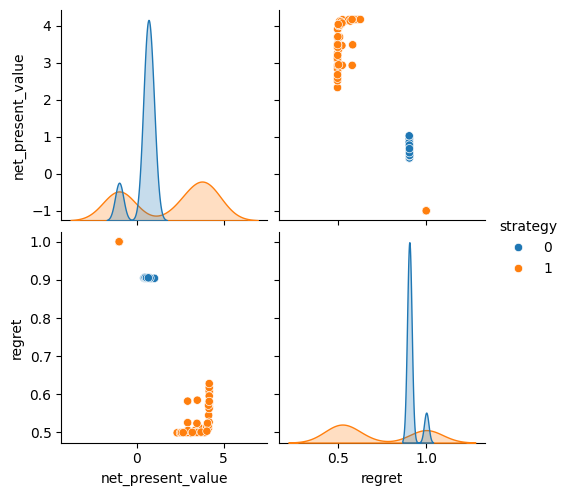

In [14]:
sns.pairplot(
    df_metrics, 
    hue = "strategy", 
    vars = list(dict_metrics.keys())
)

# James Tag

# 3. Notes
- James get environment file + installation instructions by COB
- setup a google collab
- by end of week (4/25-6) get scenario discovery in 
- try to grab the SACOG data and pull in, reach out to Edmundo about using the LAC SISEPUEDE data

# 4. Strategy Development (hecho por mano)

# 5. Compare Strategies

# 6. MORDM to Tune

###   Check if Jan has updated any of the EMA requirements or suggestions for interacting with EMA Workbench 

###  Setup a git hub today to share with Rob and Steven

# A.1. Some notes on the Jupyter notebook

##  use the `?` functionality to read function docstrings
- Provides information about arguments and the model



In [157]:
# e.g., examine information on the PredatorPreyModel
?pr.PredatorPreyModel


Init signature:
pr.PredatorPreyModel(
    predator_0: Union[float, int],
    prey_0: Union[float, int],
    n_time_periods: int,
    C: Union[float, int, NoneType] = None,
    F0: Union[float, int, NoneType] = None,
    b_min: Union[float, int, NoneType] = None,
    discount_rate: float = 0.05,
    gamma: Union[float, int, NoneType] = None,
    **kwargs,
) -> None
Docstring:     
Build a model of predator-prey interactions. Allows for the projection of 
    predator and prey populations based on INFOHERE

PARAMETERS:
    - a: prey growth parameter
    - b: inverse of predator growth parameter (1/predator growh)
    - b_min: minmium allowable value of b when subject to climate change. 
        Default is 0.25
    - gamma: exponential dependence of b on T
    - n_time_periods: number of time periods to project for
    - t: time
    - T: temperature

For information on climate parameters (including C, F, F0, and S), use
    ?ClimateChangeModel (accessible using ?PredatorPreyModel.climate_